In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import scipy
import os
from scipy.stats import linregress
from datetime import timedelta

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

plt.rcParams['figure.dpi'] = 300

## 1. Load in Files and Set Up

In [3]:
fielddata_path = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/field_data/LWC_LFM_WP_dates20230525.csv'
cwc_data_dir = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_1100_1300'

In [4]:
fielddata = pd.read_csv(fielddata_path)

lwp = fielddata[['tree','time','species','date_wp','mpa_mean']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwp['datetime_wp'] = lwp.apply(lambda x: datetime.strptime(str(x['date_wp']),'%Y-%m-%d'), axis=1)

lwa = fielddata[['tree','time','species','date_wp','lwa_g_cm2']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwa['datetime_wp'] = lwa.apply(lambda x: datetime.strptime(str(x['date_wp']),'%Y-%m-%d'), axis=1)

lwc = fielddata[['tree','time','species','date_wp','lwc_mean']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwc['datetime_wp'] = lwc.apply(lambda x: datetime.strptime(str(x['date_wp']),'%Y-%m-%d'), axis=1)

In [5]:
## Loading in CWC data...

# full_date_list = ['20220224', '20220228',  '20220308', '20220316', '20220322', '20220405', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
date_list = ['20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
datetime_list = [datetime.strptime(date, '%Y%m%d') for date in date_list]

# handling for non-convergence in the invert_liquid_water function
def kill_nans(df):
    mask = (df['CWC'] > 0.499962 - 0.0001) & (df['CWC'] < 0.499962 + 0.0001)
    df.loc[mask, 'CWC'] = np.nan
    return df

## first the full baloney of 850-1300nm
cwc_file_paths = [os.path.join(cwc_data_dir, date + '_cwc.csv') for date in date_list]
# read in one file just to get the tree numbers
cwc = pd.read_csv(cwc_file_paths[0]).set_index('Tree Number').drop(columns=['MAE', 'Intercept', 'Slope']).rename(columns={'CWC': 'CWC_' + date_list[0]})
for date, file_path in zip(date_list[1:], cwc_file_paths[1:]):
    other_df = pd.read_csv(file_path).set_index('Tree Number')
    cwc = cwc.join(other_df['CWC']).rename(columns={'CWC': 'CWC_' + date})
# now make a list of dataframes containing all the good stuff
cwc_df_list = []
for date, file_path in zip(date_list, cwc_file_paths):
    cwc_df = pd.read_csv(file_path)
    cwc_df['datetime'] = datetime.strptime(date, '%Y%m%d')
    cwc_df = kill_nans(cwc_df)
    cwc_df_list.append(cwc_df)

In [6]:
# Defining color cycle to correspond with dates, extended a lil to account for more dates
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_list.append('#000080')
color_list.append('#420303')
color_list.append('#018788')

## 2. Joining CWC and Field Data

In [7]:
## function to hunt down the MD LWP for a given tree and date
def get_midday_lwp(thisTree, imgdate):
    try:
        ourTree = int(thisTree)
    except:
        return np.NaN # specific handling for uncertainty in tree number (whoops)
    lowerDateBound = imgdate + timedelta(days=-3)
    upperDateBound = imgdate + timedelta(days=3)
    filtered = lwp[(lwp['tree']==int(thisTree)) & (lwp['time']=='md') & (lwp['datetime_wp']<=upperDateBound) & (lwp['datetime_wp']>=lowerDateBound)]
    return filtered['mpa_mean'].mean()

## function to hunt down the PD LWP for a given tree and date
def get_predawn_lwp(thisTree, imgdate):
    try:
        ourTree = int(thisTree)
    except:
        return np.NaN
    lowerDateBound = imgdate + timedelta(days=-8)
    upperDateBound = imgdate + timedelta(days=8)
    filtered = lwp[(lwp['tree']==int(thisTree)) & (lwp['time']=='pd') & (lwp['datetime_wp']<=upperDateBound) & (lwp['datetime_wp']>=lowerDateBound)]
    return filtered['mpa_mean'].mean()

## function to hunt down the MD LWC for a given tree and date
def get_midday_lwc(thisTree, imgdate):
    try:
        ourTree = int(thisTree)
    except:
        return np.NaN
    lowerDateBound = imgdate + timedelta(days=-3)
    upperDateBound = imgdate + timedelta(days=3)
    filtered = lwc[(lwc['tree']==int(thisTree)) & (lwc['time']=='md') & (lwc['datetime_wp']<=upperDateBound) & (lwc['datetime_wp']>=lowerDateBound)]
    return filtered['lwc_mean'].mean()

In [8]:
## append the LWP and LWC data to the CWC dataframes
for cwc_df in cwc_df_list:
    cwc_df['midday_lwp'] = cwc_df.apply(lambda x: get_midday_lwp(x['Tree Number'], x['datetime']), axis=1)
    cwc_df['predawn_lwp'] = cwc_df.apply(lambda x: get_predawn_lwp(x['Tree Number'], x['datetime']), axis=1)
    cwc_df['midday_lwc'] = cwc_df.apply(lambda x: get_midday_lwc(x['Tree Number'], x['datetime']), axis=1)


## 3. Make Plot

Midday LWP vs. CWC p=0.12029240544965414
Predawn LWP vs. CWC p=0.038265310984846965


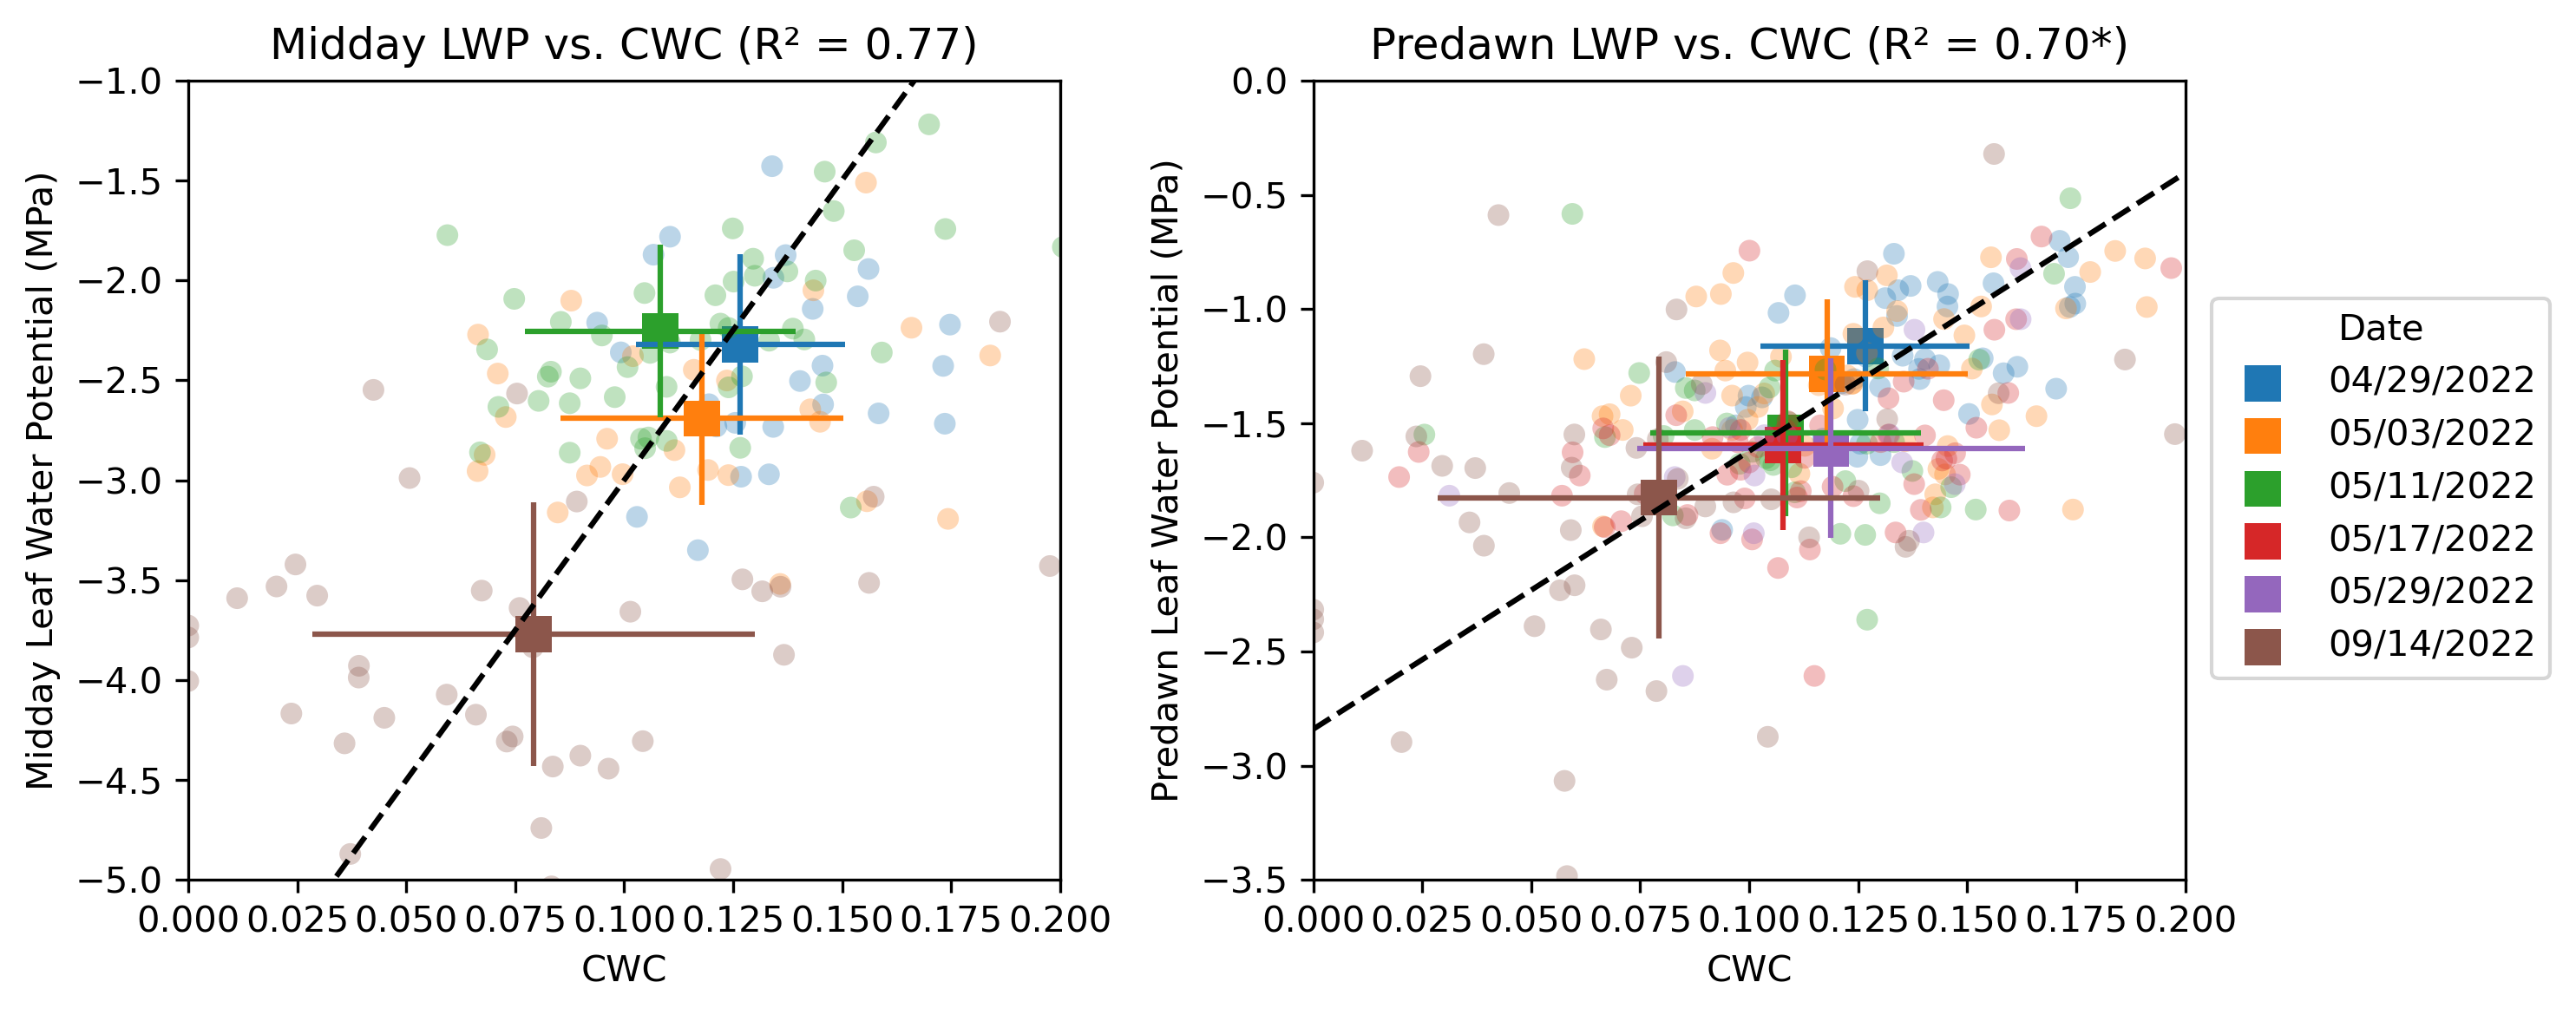

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

avg_cwcs = []
avg_midday_lwps = []

for cwc_df in cwc_df_list:
    cwc_df_dropna_md_lwp = cwc_df.dropna(subset=['midday_lwp', 'CWC'])
    if len(cwc_df_dropna_md_lwp) == 0:
        continue

    date_str = cwc_df['datetime'].iloc[0].strftime('%m/%d/%Y')
    ax1.scatter(cwc_df['CWC'], -1*cwc_df['midday_lwp'], color=color_list[date_list.index(cwc_df['datetime'].iloc[0].strftime('%Y%m%d'))], alpha=0.3, edgecolors='none')
    avg_cwc_lwp = cwc_df['CWC'].mean()
    avg_midday_lwp = -1*cwc_df['midday_lwp'].mean()
    std_cwc_lwp = cwc_df['CWC'].std()
    std_midday_lwp = cwc_df['midday_lwp'].std()
    ax1.scatter(avg_cwc_lwp, avg_midday_lwp, c=color_list[date_list.index(cwc_df['datetime'].iloc[0].strftime('%Y%m%d'))], edgecolors='none', s=100, alpha=1, marker='s', label=date_str)
    ax1.errorbar(avg_cwc_lwp, avg_midday_lwp, yerr=std_midday_lwp, fmt='none', ecolor=color_list[date_list.index(cwc_df['datetime'].iloc[0].strftime('%Y%m%d'))])
    ax1.errorbar(avg_cwc_lwp, avg_midday_lwp, xerr=std_cwc_lwp, fmt='none', ecolor=color_list[date_list.index(cwc_df['datetime'].iloc[0].strftime('%Y%m%d'))])

    avg_cwcs.append(avg_cwc_lwp)
    avg_midday_lwps.append(avg_midday_lwp)

# lin regression
slope, intercept, r_value, p_value, std_err = linregress(avg_cwcs, avg_midday_lwps)
x = np.linspace(0, 0.2, 100)
y = slope*x + intercept
ax1.plot(x, y, color='black', linestyle='--')
print('Midday LWP vs. CWC p={}'.format(p_value))

ax1.set_xlim(0, 0.2)
ax1.set_ylim(-5, -1)
ax1.set_xlabel('CWC')
ax1.set_ylabel('Midday Leaf Water Potential (MPa)')
ax1.set_title('Midday LWP vs. CWC (R² = {:.2f})'.format(r_value**2))

avg_cwcs = []
avg_predawn_lwps = []

for cwc_df in cwc_df_list:
    cwc_df_dropna_pd_lwp = cwc_df.dropna(subset=['predawn_lwp', 'CWC'])
    if len(cwc_df_dropna_pd_lwp) == 0:
        continue

    date_str = cwc_df['datetime'].iloc[0].strftime('%m/%d/%Y')
    ax2.scatter(cwc_df['CWC'], -1*cwc_df['predawn_lwp'], color=color_list[date_list.index(cwc_df['datetime'].iloc[0].strftime('%Y%m%d'))], alpha=0.3, edgecolors='none')
    avg_cwc_lwp = cwc_df['CWC'].mean()
    avg_predawn_lwp = -1*cwc_df['predawn_lwp'].mean()
    std_cwc_lwp = cwc_df['CWC'].std()
    std_predawn_lwp = cwc_df['predawn_lwp'].std()
    ax2.scatter(avg_cwc_lwp, avg_predawn_lwp, c=color_list[date_list.index(cwc_df['datetime'].iloc[0].strftime('%Y%m%d'))], edgecolors='none', s=100, alpha=1, marker='s', label=date_str)
    ax2.errorbar(avg_cwc_lwp, avg_predawn_lwp, yerr=std_predawn_lwp, fmt='none', ecolor=color_list[date_list.index(cwc_df['datetime'].iloc[0].strftime('%Y%m%d'))])
    ax2.errorbar(avg_cwc_lwp, avg_predawn_lwp, xerr=std_cwc_lwp, fmt='none', ecolor=color_list[date_list.index(cwc_df['datetime'].iloc[0].strftime('%Y%m%d'))])

    avg_cwcs.append(avg_cwc_lwp)
    avg_predawn_lwps.append(avg_predawn_lwp)

# lin regression
slope, intercept, r_value, p_value, std_err = linregress(avg_cwcs, avg_predawn_lwps)
x = np.linspace(0, 0.2, 100)
y = slope*x + intercept
ax2.plot(x, y, color='black', linestyle='--')
print('Predawn LWP vs. CWC p={}'.format(p_value))

ax2.legend(title='Date', bbox_to_anchor=(1.01, 0.75))
ax2.set_xlim(0, 0.2)
ax2.set_ylim(-3.5, 0)
ax2.set_xlabel('CWC')
ax2.set_ylabel('Predawn Leaf Water Potential (MPa)')
ax2.set_title('Predawn LWP vs. CWC (R² = {:.2f}*)'.format(r_value**2))

plt.tight_layout()
plt.show()

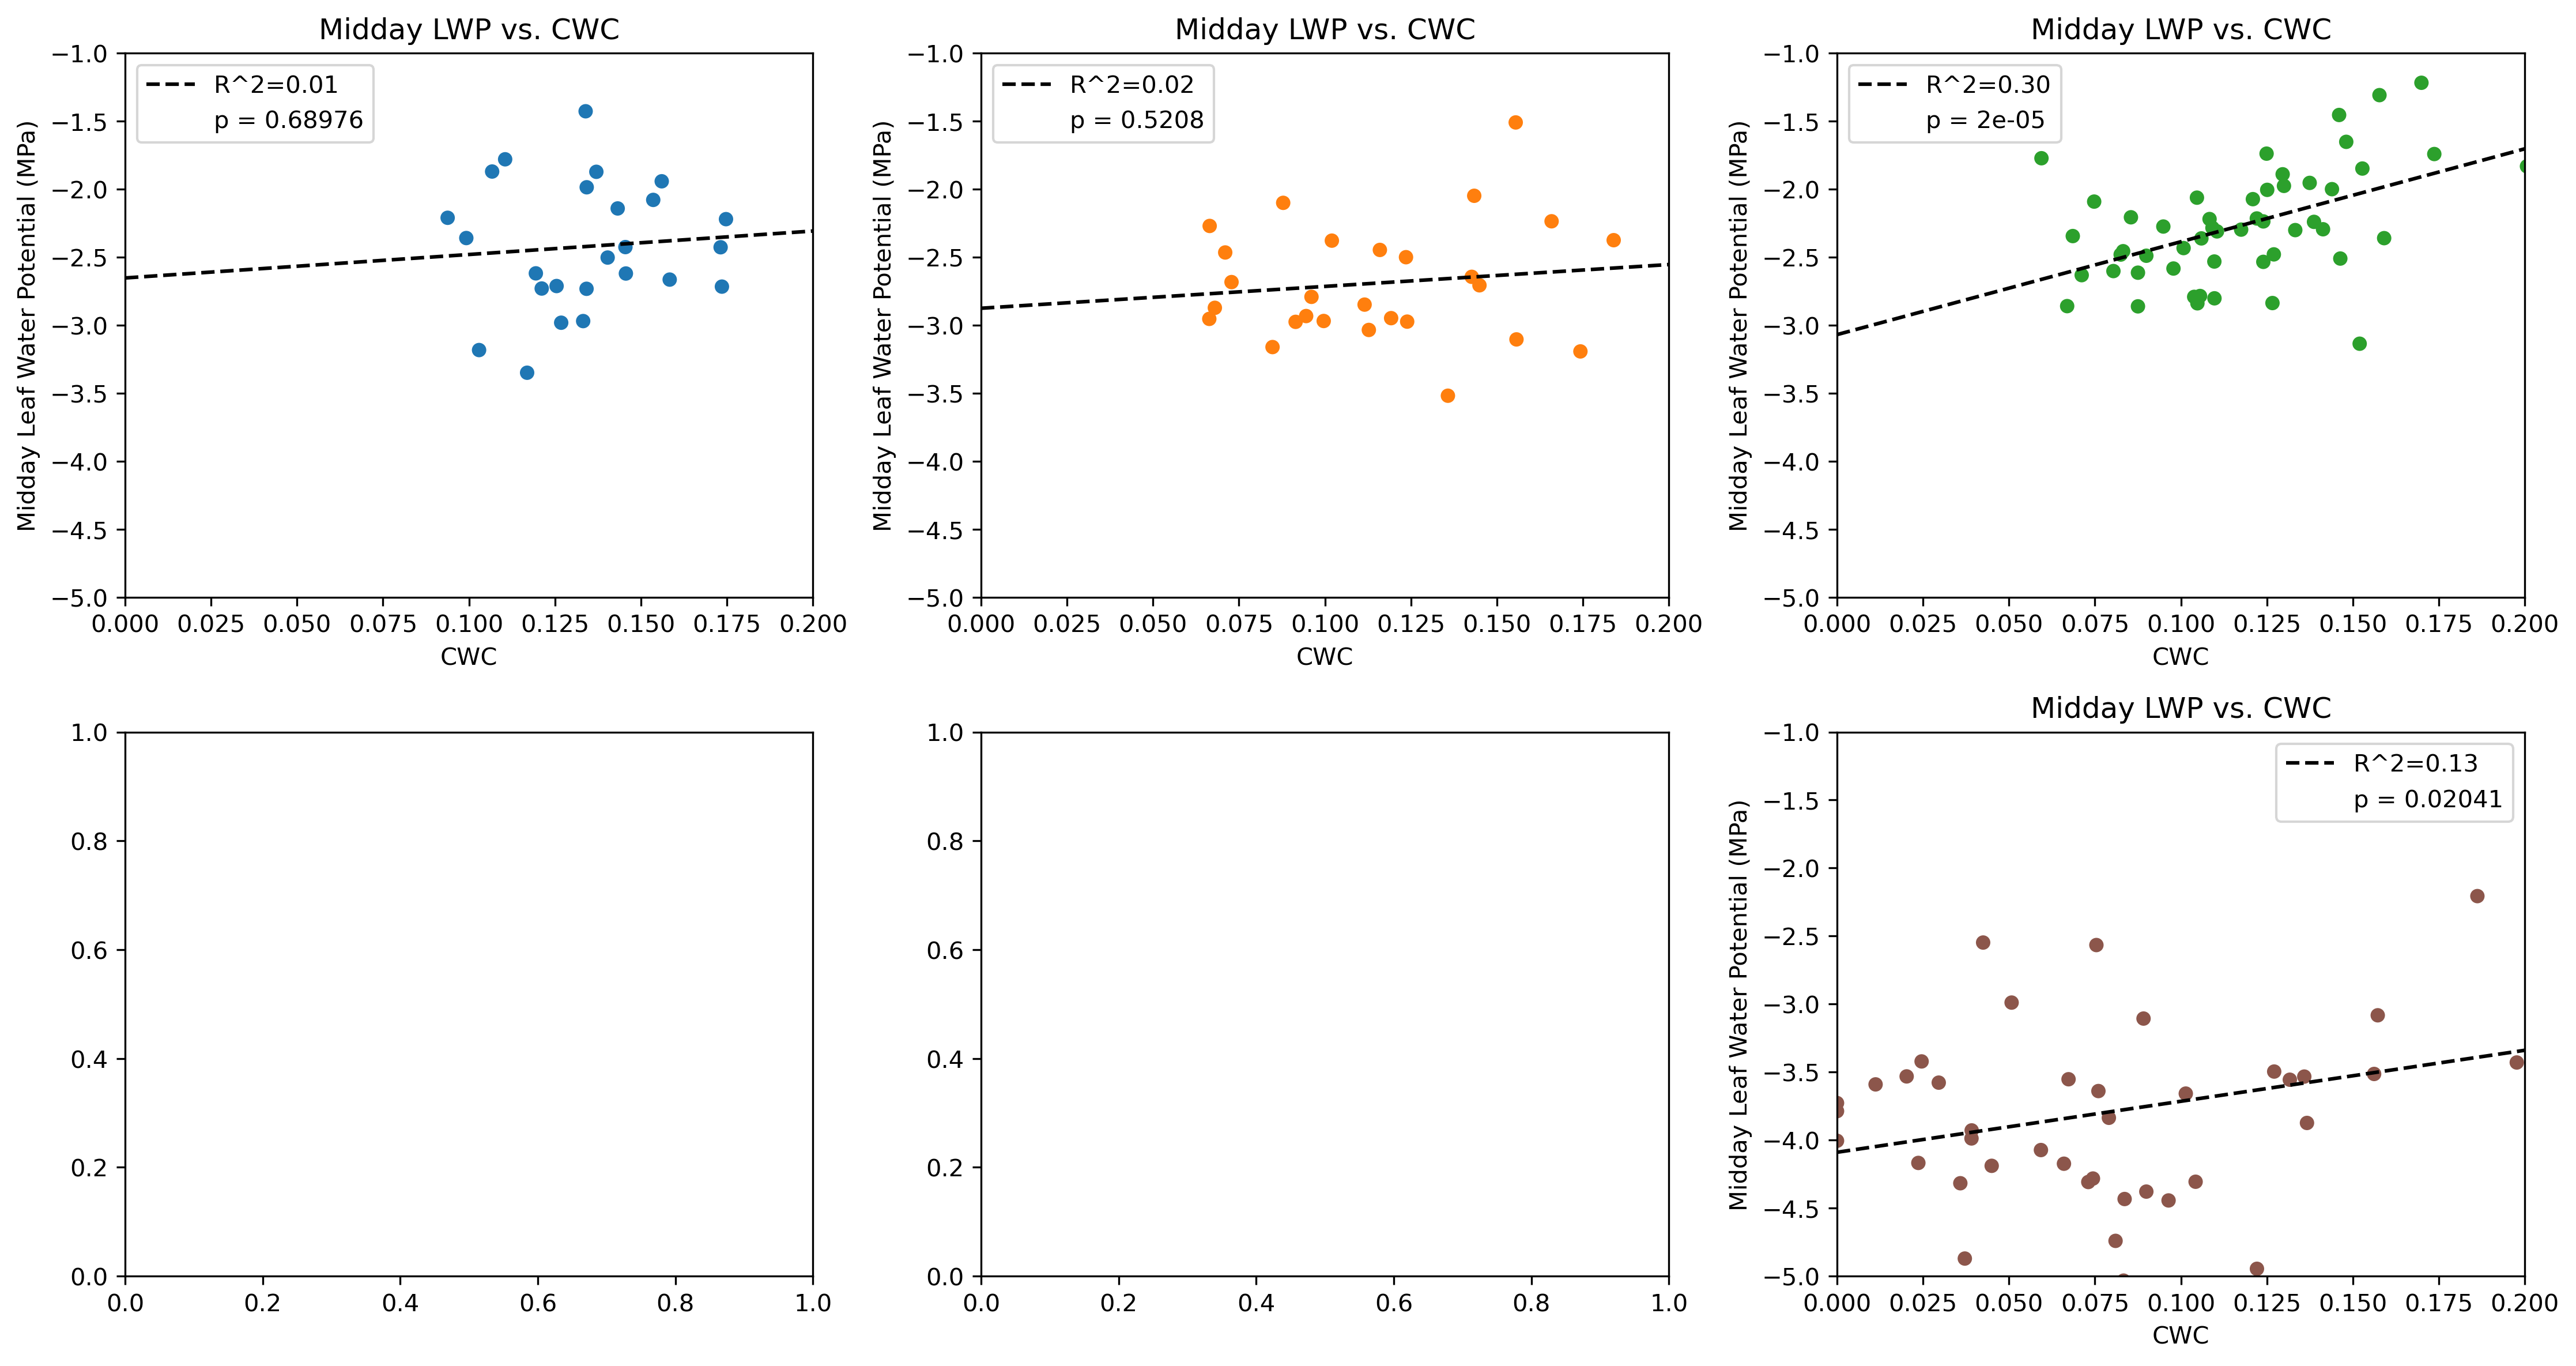

In [20]:
# now for each date on its own
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for cwc_df, ax in zip(cwc_df_list, axs.flatten()):
    cwc_df_dropna_md_lwp = cwc_df.dropna(subset=['midday_lwp', 'CWC'])
    if len(cwc_df_dropna_md_lwp) == 0:
        continue

    date_str = cwc_df['datetime'].iloc[0].strftime('%m/%d/%Y')
    no_nans = cwc_df.dropna(subset=['midday_lwp', 'CWC'])
    ax.scatter(cwc_df['CWC'], -1*cwc_df['midday_lwp'], color=color_list[date_list.index(cwc_df['datetime'].iloc[0].strftime('%Y%m%d'))], edgecolors='none')
    # linregression
    slope, intercept, r_value, p_value, std_err = linregress(no_nans['CWC'], -1*no_nans['midday_lwp'])
    x = np.linspace(0, 0.2, 100)
    y = slope * x + intercept
    ax.plot(x, y, color='black', linestyle='--', label=f'R^2={r_value**2:.2f}')
    ax.scatter([],[], c='white', label = 'p = ' + str(round(p_value, 5)))
    ax.legend()
    ax.set_xlim(0, 0.2)
    ax.set_ylim(-5, -1)
    ax.set_xlabel('CWC')
    ax.set_ylabel('Midday Leaf Water Potential (MPa)')
    ax.set_title('Midday LWP vs. CWC')

plt.tight_layout()
plt.show()

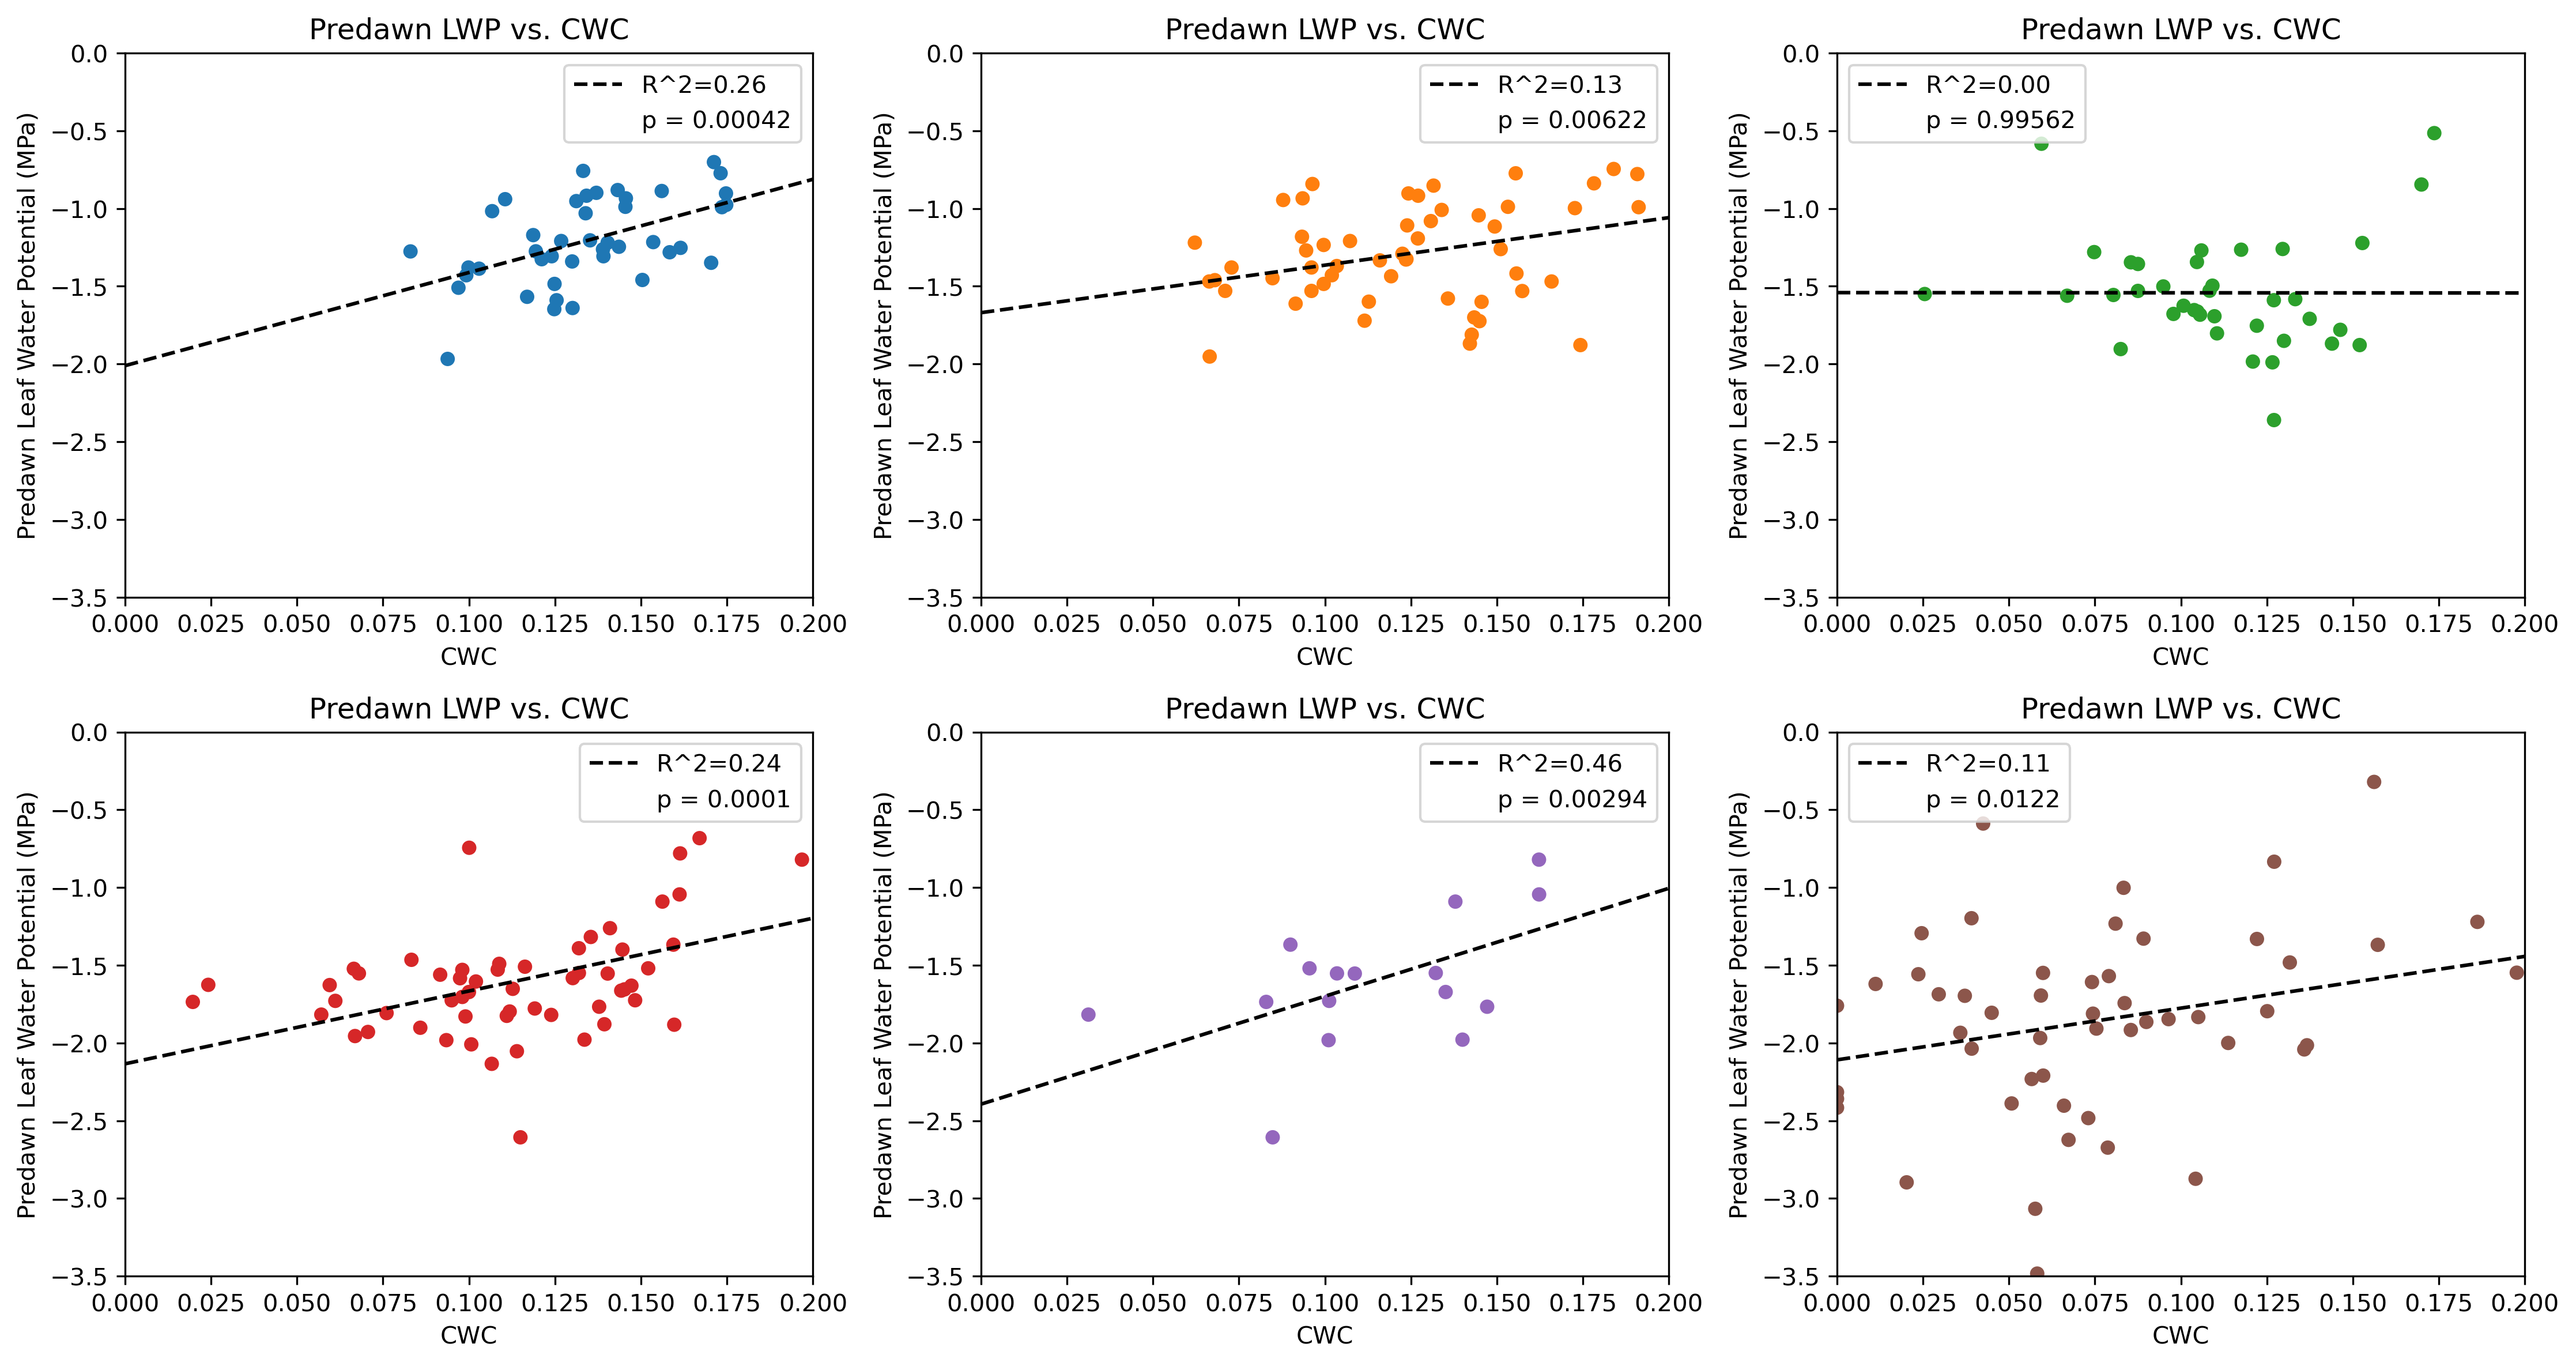

In [21]:
# again for predawn
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for cwc_df, ax in zip(cwc_df_list, axs.flatten()):
    cwc_df_dropna_pd_lwp = cwc_df.dropna(subset=['predawn_lwp', 'CWC'])
    if len(cwc_df_dropna_pd_lwp) == 0:
        continue

    date_str = cwc_df['datetime'].iloc[0].strftime('%m/%d/%Y')
    no_nans = cwc_df.dropna(subset=['predawn_lwp', 'CWC'])
    ax.scatter(cwc_df['CWC'], -1*cwc_df['predawn_lwp'], color=color_list[date_list.index(cwc_df['datetime'].iloc[0].strftime('%Y%m%d'))], edgecolors='none')
    # linregression
    slope, intercept, r_value, p_value, std_err = linregress(no_nans['CWC'], -1*no_nans['predawn_lwp'])
    x = np.linspace(0, 0.2, 100)
    y = slope * x + intercept
    ax.plot(x, y, color='black', linestyle='--', label=f'R^2={r_value**2:.2f}')
    ax.scatter([],[], c='white', label = 'p = ' + str(round(p_value, 5)))
    ax.legend()
    ax.set_xlim(0, 0.2)
    ax.set_ylim(-3.5, 0)
    ax.set_xlabel('CWC')
    ax.set_ylabel('Predawn Leaf Water Potential (MPa)')
    ax.set_title('Predawn LWP vs. CWC')

plt.tight_layout()
plt.show()